## Downloading WISE Data

## Reprocessing WISE Data

## Analysis and Results

In [14]:
from os.path import join as pjoin
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
from easycat.subcat2d import grid

from easycat.lightcurve.features import \
    intrinsic_variability_amplitude, peak_to_peak_amplitude, fractional_variability_amplitude

from scipy.stats import pearsonr
from config_jhwu import CONFIG

catalog = pd.read_csv(CONFIG.get("CATALOG_REPRO_PATH"))
catalog.set_index("obj_id", inplace=True)
len(catalog)

3841

In [2]:
REPRO_DIR = CONFIG.get("REPRO_DIR")
ERR_SYS_W1 = CONFIG.get("ERR_SYS_W1")
ERR_SYS_W2 = CONFIG.get("ERR_SYS_W2")

for obj_id, row in catalog.iterrows():
    filepath = pjoin(REPRO_DIR, obj_id + ".csv")
    lc = pd.read_csv(filepath)

    z = row["z"]
    color = lc.w1mag - lc.w2mag
    Cmin = np.min(color)
    Cmax = np.max(color)
    rho_p, pvalue_p = pearsonr(lc.w1mag, color)

    # 变异性计算, 考虑系统误差
    w1err = np.sqrt(lc.w1sigmag**2 + ERR_SYS_W1**2)
    w2err = np.sqrt(lc.w2sigmag**2 + ERR_SYS_W2**2)
    w1epsilon = np.sqrt(np.mean(w1err**2))
    w2epsilon = np.sqrt(np.mean(w2err**2))
    w1varamp    = intrinsic_variability_amplitude(lc.w1mag, w1err, is_weighted=True)
    w2varamp    = intrinsic_variability_amplitude(lc.w2mag, w2err, is_weighted=True)
    w1varamp_pp = peak_to_peak_amplitude(lc.w1mag, w1err)
    w2varamp_pp = peak_to_peak_amplitude(lc.w2mag, w2err)
    w1varamp_f  = fractional_variability_amplitude(lc.w1mag, w1err)
    w2varamp_f  = fractional_variability_amplitude(lc.w2mag, w2err)

    catalog.loc[
        obj_id,
        [
            "Cmin", "Cmax", "w1epsilon", "w2epsilon",
            "w1varamp", "w2varamp", "w1varamp_pp", "w2varamp_pp", "w1varamp_f", "w2varamp_f",
            "rho_pearson", "pvalue_pearson"
        ]
    ] =\
        (Cmin, Cmax, w1epsilon, w2epsilon, w1varamp, w2varamp, w1varamp_pp, w2varamp_pp, w1varamp_f, w2varamp_f, rho_p, pvalue_p)



Text(0, 0.5, '$\\rm \\Delta C = C_{max}-C_{min}$')

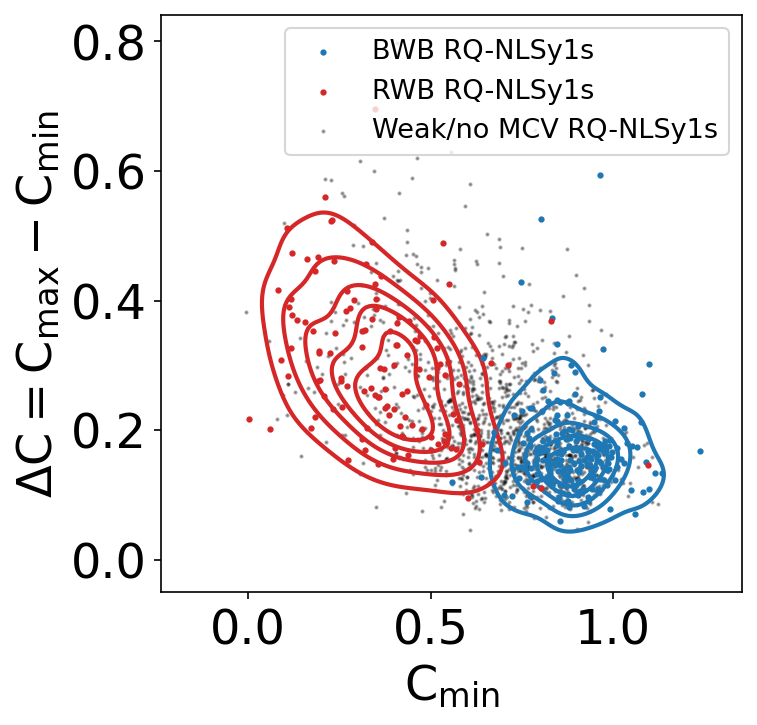

In [12]:

cat = catalog[
    (catalog.w1varamp/catalog.w1epsilon > 2) & (catalog.w2varamp/catalog.w2epsilon > 2)
]

rho = cat.rho_pearson
pvalue = cat.pvalue_pearson

BWB = cat[(rho>0.6) & (pvalue<0.05)]
RWB = cat[(rho<-0.6) & (pvalue<0.05)]
Weak = cat[(np.abs(rho)<=0.6) | (pvalue>=0.05)]

plt.rc('font', size=23)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

sns.kdeplot(data={
    "Cmin": BWB.Cmin,
    "dC": BWB.Cmax-BWB.Cmin
}, x="Cmin", y="dC", color="tab:blue", ax=ax, levels=6, zorder=1, thresh=0.1, linewidths=2)

sns.kdeplot(data={
    "Cmin": RWB.Cmin,
    "dC": RWB.Cmax-RWB.Cmin
}, x="Cmin", y="dC", color="tab:red", ax=ax, levels=6, zorder=1, thresh=0.2, linewidths=2)

ax.scatter(BWB.Cmin, BWB.Cmax-BWB.Cmin, c="tab:blue", s=4, label="BWB RQ-NLSy1s")
ax.scatter(RWB.Cmin, RWB.Cmax-RWB.Cmin, c="tab:red", s=4, label="RWB RQ-NLSy1s")
ax.scatter(Weak.Cmin, Weak.Cmax-Weak.Cmin, c="k", s=1, alpha=0.3, label="Weak/no MCV RQ-NLSy1s", zorder=-2)


ax.legend(fontsize=13)
ax.set_xlabel("$\\rm C_{min}$")
ax.set_ylabel("$\\rm \\Delta C = C_{max}-C_{min}$")

In [13]:
edge_MBH = np.array([5.7, 6, 6.3, 6.6, 6.9, 7.2, 7.5, 7.8]) - 0.5
edge_L = np.array([42.7, 43, 43.3, 43.6, 43.9, 44.2, 44.5, 44.8, 45.1, 45.4, 45.7])

grid_result = grid.regular_grid_map(
    cat, "M_BH", "L_BOL",
    edge_MBH, edge_L,
    mapper = lambda data: np.nanmedian(data.rho_pearson),
    need_rects=True
)

num = grid_result.get("num")
mask = num > 20

X1 = grid_result.get("X1")[mask]
X2 = grid_result.get("X2")[mask]
Rho = grid_result.get("Y")[mask]
rects_attr = grid_result.get("rects")[mask]

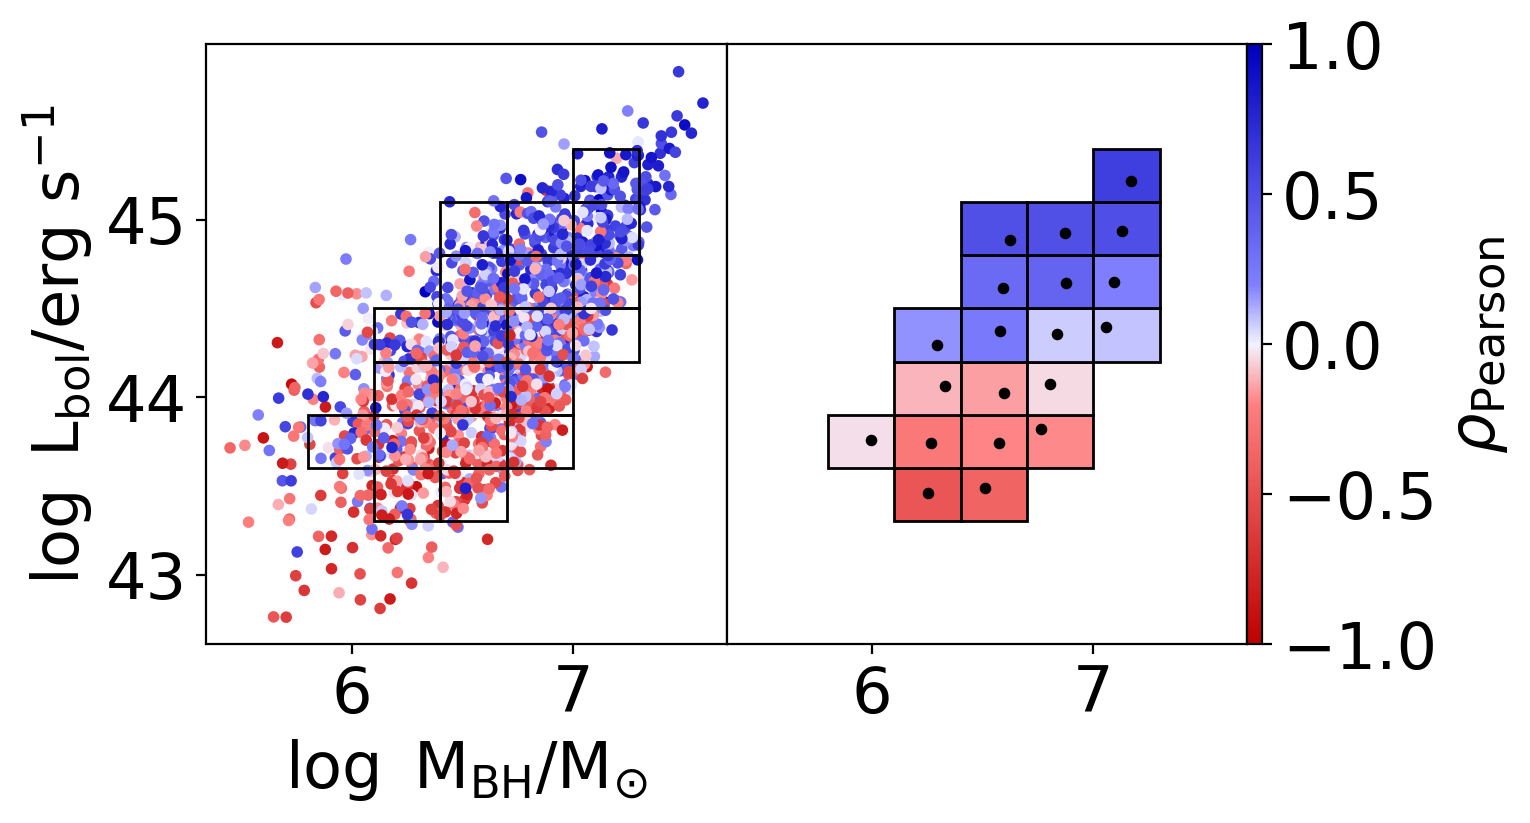

In [15]:
colors = [
    (0.75, 0, 0),     # z_min: 深红
    (1.0, 0.5, 0.5),  # z=0-: 浅红
    (0.95, 0.95, 1),  # z=0: 白色
    (0.5, 0.5, 1.0),  # z=0+: 浅蓝
    (0, 0, 0.75)      # z_max: 深蓝
]

positions = [0.0, 0.4, 0.5, 0.6, 1.0]
cmap_custom = LinearSegmentedColormap.from_list(
    "RedBlue", list(zip(positions, colors))
)
norm = plt.Normalize(vmin=-1, vmax=1)

fig, axs = plt.subplots(1, 3, figsize=(8, 4), dpi=200, width_ratios=[1, 1, 0.03])
axs[0].scatter(cat.M_BH, cat.L_BOL, c=cat.rho_pearson, marker="o", s=10, cmap=cmap_custom, norm=norm)
axs[1].scatter(X1, X2, c="k", marker="o", s=10, zorder=99999)

for (x1, x2, width1, width2), rho in zip(rects_attr, Rho):
    rect_param = {
        "xy": (x1, x2),
        "width": width1,
        "height": width2,
        "edgecolor": "k"
    }

    rect = patches.Rectangle(**rect_param, facecolor=cmap_custom(norm(rho)))
    axs[1].add_patch(rect)

    rect = patches.Rectangle(**rect_param, facecolor='none')
    axs[0].add_patch(rect)

axs[0].set_xlabel("$\\rm \\log~M_{BH}/M_{\\odot}$")
axs[0].set_ylabel("$\\rm \\log~L_{bol}/erg~s^{-1}$")

axs[1].sharex(axs[0])
axs[1].sharey(axs[0])
axs[1].yaxis.set_visible(False)

sm = ScalarMappable(cmap=cmap_custom, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=axs[2], ax=axs[2], label='$\\rho_{\\rm Pearson}$')
axs[2].set_ylim(-1, 1)

fig.subplots_adjust(wspace=0, left=0.15, right=0.81, top=0.95, bottom=0.2)